In [1]:
# the classics
import pandas as pd
import numpy as np
import os 
import glob as glob
import scipy
import hydroeval as he

# hydroeval for NSE, KGE
import hydroeval as he

# my helperfunctions as defined in notebook 3
from helperfunctions import *

# plotting stuff
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

Test 1: evaluate uncertainty when we provide all parameters necessary for the stream network model, including groundwater DIC (from springs) and k600 (from reported scaling relationships)

In [2]:
# read in merged network dataframe
df = pd.read_csv('map/network_merged.csv',index_col=0)

In [3]:
# calculate k600 8 different ways

##### ULSETH

df['ed'] = 9.81*df['velocity']*-df['slope']

df.loc[df['ed']==0,'ed'] = np.min(df.loc[df['ed']>0,'ed']) # where ed = 0 set to min non-zero

# regular
df.loc[df['ed']<0.02,'k600_ulseth'] = np.exp(0.35*np.log(df.loc[df['ed']<0.02,'ed'])+3.10)
df.loc[np.isnan(df['ed']),'k600_ulseth'] = np.nanmin(df.loc[df['ed']<0.02,'k600_ulseth'])
df.loc[df['ed']>0.02,'k600_ulseth'] = np.exp(1.18*np.log(df.loc[df['ed']>0.02,'ed'])+6.43)

# high
df.loc[df['ed']<0.02,'k600_ulseth_high'] = np.exp(0.31*np.log(df.loc[df['ed']<0.02,'ed'])+3.10)
df.loc[np.isnan(df['ed']),'k600_ulseth_high'] = np.nanmin(df.loc[df['ed']<0.02,'k600_ulseth'])
df.loc[df['ed']>0.02,'k600_ulseth_high'] = np.exp(1.1*np.log(df.loc[df['ed']>0.02,'ed'])+6.43)

# low
df.loc[df['ed']<0.02,'k600_ulseth_low'] = np.exp(0.41*np.log(df.loc[df['ed']<0.02,'ed'])+3.10)
df.loc[np.isnan(df['ed']),'k600_ulseth_low'] = np.nanmin(df.loc[df['ed']<0.02,'k600_ulseth'])
df.loc[df['ed']>0.02,'k600_ulseth_low'] = np.exp(1.3*np.log(df.loc[df['ed']>0.02,'ed'])+6.43)


### Raymond et al., 2012 k600s.... they report SD so get 5-95 by SD*2
df['Fr'] = df['velocity']/((df['depth']*9.81)**0.5)

#r1   0.89  0.020    0.54 – 0.030 5037 – 604
df['k600_r1'] = (df['velocity']*-df['slope'])**0.89 * df['depth']**0.54 * 5037
df['k600_r1_low'] = (df['velocity']*-df['slope'])**(0.89+0.02*2) * df['depth']**(0.54+0.03*2) * (5037-604*2)
df['k600_r1_high'] = (df['velocity']*-df['slope'])**(0.89-0.02*2) * df['depth']**(0.54-0.03*2) * (5037+604*2)

# r2 5937 – 606 0.89 – 0.017  0.58 – 0.027
df['k600_r2'] = (5937)*(1-2.54*df['Fr']**2)*(df['velocity']*-df['slope'])**0.89 * df['depth']*0.58
df['k600_r2_low'] = (5937-606*2)*(1-2.32*df['Fr']**2)*(df['velocity']*-df['slope'])**(0.89+0.017*2) * df['depth']*(0.58-0.027*2)
df['k600_r2_high'] = (5937+606*2)*(1-2.76*df['Fr']**2)*(df['velocity']*-df['slope'])**(0.89-0.017*2) * df['depth']*(0.58+0.027*2)

#r3 0.77 – 0.028 0.85 – 0.045
df['k600_r3'] = 1162*(-df['slope'])**0.77 * df['velocity']**0.85
df['k600_r3_low'] = 970*(-df['slope'])**(0.77+0.028*2) * df['velocity']**(0.85+0.045*2)
df['k600_r3_high'] = 1354*(-df['slope'])**(0.77-0.028*2) * df['velocity']**(0.85-0.045*2)

# r4 0.76 – 0.027 · 951.5 – 144
df['k600_r4'] = (df['velocity']*-df['slope'])**0.76 * 951.5
df['k600_r4_high'] = (df['velocity']*-df['slope'])**(0.76+0.027*2) * (951.5-144*2)
df['k600_r4_low'] = (df['velocity']*-df['slope'])**(0.76-0.027*2) * (951.5+144*2)

# r5 2841 – 107 + 2.02 – 0.209
df['k600_r5'] = df['velocity']*-df['slope']*2841+2.02
df['k600_r5_low'] = df['velocity']*-df['slope']*(2841-107*2)+(2.02-0.209*2)
df['k600_r5_high'] = df['velocity']*-df['slope']*(2841+107*2)+(2.02+0.209*2)

#r6 929 – 141 · (VS) 0.75 – 0.027 · Q 0.011 – 0.016
df['k600_r6'] = 929*(df['velocity']*-df['slope'])**0.75 * df['discharge']**0.011 # discharge is in m^3/s
df['k600_r6_low'] = (929-141*2)*(df['velocity']*-df['slope'])**(0.75+0.027*2) * df['discharge']**(0.011+0.016*2) # discharge is in m^3/s
df['k600_r6_high'] = (929+141*2)*(df['velocity']*-df['slope'])**(0.75-0.027*2) * df['discharge']**(0.011-0.016*2) # discharge is in m^3/s

# r7   4725 – 445 · (VS) 0.86 – 0.016 · Q -0.14 – 0.012 · D 0.66 – 0.029
df['k600_r7'] = 4725*(df['velocity']*-df['slope'])**0.86 * df['discharge']**-0.14 * df['depth']**0.66
df['k600_r7_low'] = (4725-445*2)*(df['velocity']*-df['slope'])**(0.86+0.016*2) * df['discharge']**(-0.14+0.012*2) * df['depth']**(0.66+0.029*2)
df['k600_r7_high'] = (4725+445*2)*(df['velocity']*-df['slope'])**(0.86-0.016*2) * df['discharge']**(-0.14-0.012*2) * df['depth']**(0.66-0.029*2)

In [4]:
### Initialize

## read in additional chem data
chemdf = pd.read_csv('data/watersamples_merged.csv',parse_dates=['datetime'],na_values=['nan','NAN','ibid'])
chemdf = chemdf.loc[chemdf['datetime'].dt.year>2021,:]

# define other sample groups
pzs = chemdf.loc[chemdf['sample_type']=='PZ',:]
springs = chemdf.loc[chemdf['sample_type']=='SP',:]
ponds = chemdf.loc[chemdf['sample_type']=='P',:]

## these are the endmembers
gw_DIC_delta = np.nanmean(springs['d13C_permil'])
gw_CO2_delta = np.nanmean(springs['d13c_co2'])
gw_rn = np.nanmean(springs['Rn_bq_m3'])
gw_alk = np.nanmean(df['Alkalinity_meq_L'])/1000 # mean of streams

# rescale Rn by alk to adjust for diff alk in springs and streams
gw_rnratio = gw_rn/(np.mean(springs['Alkalinity_meq_L']/1000))

# getting DIC to alk ratio for springs, so we can adjust them to mean stream alk
gw_DICratio_mean = np.nanmean(springs['dic_calc']/1000/springs['Alkalinity_meq_L'])
gw_DICratio_high = np.nanmax(springs['dic_calc']/1000/springs['Alkalinity_meq_L'])
gw_DICratio_low = np.nanmin(springs['dic_calc']/1000/springs['Alkalinity_meq_L'])
print(f'mean gw DICratio: {gw_DICratio_mean:.2f} min: {gw_DICratio_low:.2f} max: {gw_DICratio_high:.2f}')
gw_DIC = gw_DICratio_mean*gw_alk
gw_DIC_high = gw_DICratio_high*gw_alk
gw_DIC_low = gw_DICratio_low*gw_alk

# some other constants
# some other constants
kh = np.mean(df['KHenry'])# Henrys law, Molar / atm
pCO2_atm = 420 # pco2 in atmosphere
c_atm = kh * pCO2_atm/1e6 # convert pCO2 to atm (ppm -> 1e6) this is 2.45e-5 Saccardi Winnick used c_atm = 2.13e-5
co2_delta_atm = -9 # co2 isotope content in atm
c_iso_atm = c_atm*delta2r(co2_delta_atm) # convert to concentraiton of 13C
delta_x=10 # length of cell in network = 10m
mintemp = np.min(df['temperature_filled']) # save mintemp for later


mean gw DICratio: 1.38 min: 1.13 max: 1.88


In [5]:
table2 = pd.DataFrame(index=['k600','Groundwater DIC',
'Groundwater alkalinity','Groundwater $\delta^{13}$C-CO$_{2}$','Groundwater $^{222}$Rn',
                             'Atmospheric pCO$_{2}$','Atmospheric $\delta^{13}$C-CO$_{2}$'])



table2['units'] = ['m day$^{-1}$','mM','mEq L$^{-1}$','‰','(Bq m$^{-3}$)','ppmv','‰']

table2['value'] = ['Equations 1-8 (see Supplement)',round(gw_DIC*1e3,3),round(gw_alk*1e3,3),round(gw_CO2_delta,2),int(round(gw_rn,0)),420,-9.0]

table2['propagated error'] = ['5-95% CI (see Supplement)',f'{round(gw_DIC_low*1e3,3)}-{round(gw_DIC_high*1e3,3)}','-','-','-','-','-']

table2.to_csv('tables/Table2.csv')
table2

,units,value,propagated error
k600,m day$^{-1}$,Equations 1-8 (see Supplement),5-95% CI (see Supplement)
Groundwater DIC,mM,0.445,0.365-0.609
Groundwater alkalinity,mEq L$^{-1}$,0.323,-
Groundwater $\delta^{13}$C-CO$_{2}$,‰,-26.06,-
Groundwater $^{222}$Rn,(Bq m$^{-3}$),659,-
Atmospheric pCO$_{2}$,ppmv,420,-
Atmospheric $\delta^{13}$C-CO$_{2}$,‰,-9.0,-


In [6]:
### set parameters that we will vary

klist_short = ['ulseth','r1','r2','r3','r4','r5','r6','r7']

# add low and high to propagate k600 uncertainty
klist_low = [item + '_low' for item in klist_short]
klist_high = [item + '_high' for item in klist_short]

# make a test df
testdf = pd.DataFrame()
# make k600 test cases
testdf['k600'] =klist_short+klist_low+klist_high+klist_short+klist_short+klist_low+klist_high
# make gw test cases
testdf['gw'] = ['mean']*len(klist_short+klist_low+klist_high)+['low']*len(klist_short)+['high']*len(klist_short)+['low']*len(klist_short)+['high']*len(klist_short)

# some more combos
klist_lowgw = [item + '-lowgw' for item in klist_short]
klist_highgw = [item + '-highgw' for item in klist_short]
klist_lowlow = [item + '-lowlow' for item in klist_short]
klist_highhigh = [item + '-highhigh' for item in klist_short]

# long list of test combos
klist_long = klist_short+klist_low+klist_high+klist_lowgw+klist_highgw

# rename columns 
df =df.rename(columns={'d13C_permil':'dic_delta_meas','dic_calc':'dic_meas','pco2':'pco2_meas','Rn_bq_m3':'rn_meas'})

In [7]:
# print all the test cases
testdf

,k600,gw
0,ulseth,mean
1,r1,mean
2,r2,mean
3,r3,mean
4,r4,mean
5,r5,mean
6,r6,mean
7,r7,mean
8,ulseth_low,mean
9,r1_low,mean


In [8]:
# %%writefile networkmodelmc.py
import pandas as pd
import numpy as np
import hydroeval as he
import scipy
import time
import os


df =df.rename(columns={'d13C':'dic_delta_meas','DIC':'dic_meas','pco2':'pco2_meas','Rn':'rn_meas'})
upstreamnetwork = pd.read_csv('map/network_upstream.csv',index_col=0)

strahlerlist = [1,2,3,4]

def networkmodel_test1(inputs):
    
    df_iter = df.copy()
    lastcell = pd.DataFrame()

    [k,gw_dic,gw_rn] = inputs
    
    result=pd.Series()
    result['k600_used'] = k
    result['gw_used'] = gw_dic    
    
    # intitialize
    if gw_dic=='mean':
        gw_DICratio = gw_DICratio_mean
    if gw_dic=='low':
        gw_DICratio = gw_DICratio_low
    if gw_dic=='high':
        gw_DICratio = gw_DICratio_high  
    
    mcresults = pd.DataFrame()

    gw_DIC_delta = epsilon_co2_dic(gw_DICratio*gw_alk,gw_alk,gw_CO2_delta,mintemp)
    gw_pco2 = phfromalk(gw_DICratio*gw_alk,gw_alk,mintemp)[-1]
    
    # intitialize
    df_iter['co2_atm'] = henryco2(df_iter['temperature_filled'])  * pCO2_atm/10**6# this is 2.14e-5 Saccardi Winnick used c_atm = 2.13e-5
    df_iter['co2_iso_atm'] = df_iter['co2_atm']*delta2r(co2_delta_atm)

    s_co2 = schmidtco2(df_iter['temperature_filled'])
    s_rn = schmidtrn(df_iter['temperature_filled'])

    df_iter['kco2'] = (df_iter[f'k600_{k}']/(600/s_co2)**-0.5)/(24*60*60) # m/day to m/s
    df_iter['krn'] = (df_iter[f'k600_{k}']/(600/s_rn)**-0.5)/(24*60*60)
    df_iter.loc[np.isnan(df_iter['kco2']),'kco2'] = np.nanmin(df_iter.loc[df_iter['kco2']>0,'kco2'])
    df_iter.loc[np.isnan(df_iter['krn']),'krn'] = np.nanmin(df_iter.loc[df_iter['krn']>0,'krn'])

    toponums = list(set(df['topo']))

    for t in list(reversed(toponums)):

        tempdf_topo = df_iter.loc[df_iter['topo']==t,:]

        segmentlist = set(tempdf_topo['stream'])

        for seg in segmentlist:
            tempdf = tempdf_topo.loc[tempdf_topo['stream']==seg,:]

            temp_strahl = tempdf['strahler'].values[0]

            tempindex = tempdf_topo.loc[tempdf_topo['stream']==seg,:].index

            gw_DIC = gw_alk*gw_DICratio

            if temp_strahl>1:
                tribs = set(df_iter.loc[df_iter['next_stream']==seg,'stream'])
                tribs=upstreamnetwork[upstreamnetwork['down']==seg].index

                if any(np.isnan(lastcell.loc[lastcell['stream'].isin(tribs),'dic'])):
                    print(f'AHHHHH {seg} tribs are bad :0')

                # discharge weighted mixtures
                mix_DIC = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'dic']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_DIC_delta = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'dic_delta']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_rn = np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'rn']*lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])/np.sum(lastcell.loc[lastcell['stream'].isin(tribs),'discharge'])
                mix_DIC = np.nanmax([mix_DIC,gw_alk+0.00002]) # when DIC is exactly equal to alk, things blow up
                
                df_iter.loc[tempindex[0],'dic']= mix_DIC
                
                [ph,co2,bicarb,carb,pco2] = phfromalk(mix_DIC,gw_alk,df_iter.loc[tempindex[0],'temperature_filled'])
                
                df_iter.loc[tempindex[0],'co2'] = co2
                df_iter.loc[tempindex[0],'dic_iso']= mix_DIC*delta2r(mix_DIC_delta)
                df_iter.loc[tempindex[0],'co2_iso']= delta2r(epsilon_dic_co2(mix_DIC,gw_alk,mix_DIC_delta,df_iter.loc[tempindex[0],'temperature_filled']))*df_iter.loc[tempindex[0],'co2']
                df_iter.loc[tempindex[0],'rn']= mix_rn


            else: # if first order, first value is just groundwater
                df_iter.loc[tempindex[0],'dic']= gw_DIC/1
                [ph,co2,bicarb,carb,pco2] = phfromalk(gw_DIC,gw_alk,df_iter.loc[tempindex[0],'temperature_filled'])
                df_iter.loc[tempindex[0],'co2'] =co2
                df_iter.loc[tempindex[0],'dic_iso']= gw_DIC*delta2r(gw_DIC_delta)
                df_iter.loc[tempindex[0],'co2_iso']= delta2r(epsilon_dic_co2(gw_DIC,gw_alk,gw_DIC_delta,df_iter.loc[tempindex[0],'temperature_filled']))*df_iter.loc[tempindex[0],'co2']
                df_iter.loc[tempindex[0],'rn']= gw_rn

            for i in tempindex[1:]:
     
                c_gw = gw_alk*gw_DICratio
                c_delta_gw = gw_DIC_delta
                c_iso_gw = c_gw*delta2r(c_delta_gw)

                df_iter.loc[i,'deltaq'] = df_iter.loc[i,'discharge']-df_iter.loc[i-1,'discharge']

                # Rn steady state solution: in - out
                rn_ss_in = (df_iter.loc[i-1,'rn']*df_iter.loc[i-1,'discharge']+gw_rn*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                rn_ss_out = (df_iter.loc[i,'krn']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'rn']-0)*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available (0 in atm)
                if rn_ss_out>=rn_ss_in:
                    rn_ss_out = rn_ss_in # substracting a small number so its early equivalent but result is not zero. might not be necessary

                df_iter.loc[i,'rn'] = rn_ss_in-rn_ss_out

                # CO2 steady state solution: in - out
                dic_ss_in = (df_iter.loc[i-1,'dic']*df_iter.loc[i-1,'discharge']+c_gw*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                co2_ss_out = (df_iter.loc[i,'kco2']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm'])*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available (some co2 in atm)
                if co2_ss_out>=df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm']:
                    co2_ss_out = df_iter.loc[i-1,'co2']-df_iter.loc[i-1,'co2_atm'] # substracting a small number so its early equivalent but result is not zero. might not be necessary

                df_iter.loc[i,'dic'] = dic_ss_in-co2_ss_out

                # now copy co2_ss_out into flux of co2 out... right now it is normalized to discharge (m/s / m) *(mol/L) * m*m^2 / (m3/s)  -> mol/L * m^3/s  /(m^3 /s)
                # and also convert mol/L to mol/ m^3
                df_iter.loc[i,'fco2'] = co2_ss_out*df_iter.loc[i,'discharge']*1000*12*(24*60*60)
                df_iter.loc[i,'fco2_perarea'] = co2_ss_out*df_iter.loc[i,'discharge']*1000*12*(24*60*60)/(delta_x*df_iter.loc[i,'width'])

                # now speciate using DIC and alk
                [ph,co2,bicarb,carb,pco2] = phfromalk(df_iter.loc[i,'dic'],gw_alk,df_iter.loc[i,'temperature_filled'])
                df_iter.loc[i,'co2'] = co2

                ## iso
                # isotope CO2 steady state solution: in - out
                dic_iso_ss_in = (df_iter.loc[i-1,'dic_iso']*df_iter.loc[i-1,'discharge']+c_iso_gw*df_iter.loc[i,'deltaq'])/(df_iter.loc[i,'discharge'])
                co2_iso_ss_out = (df_iter.loc[i,'kco2']/df_iter.loc[i,'depth'])*(df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm'])*delta_x*df_iter.loc[i-1,'xarea']/(df_iter.loc[i,'discharge'])

                # we cant degas more than what is available
                if co2_iso_ss_out>=df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm']:
                    co2_iso_ss_out = df_iter.loc[i-1,'co2_iso']-df_iter.loc[i-1,'co2_iso_atm'] # substracting a small number so its early equivalent but result is not zero. might not be necessary


                df_iter.loc[i,'dic_iso'] = dic_iso_ss_in-co2_iso_ss_out

                df_iter.loc[i,'dic_delta'] = r2delta(df_iter.loc[i,'dic_iso']/df_iter.loc[i,'dic'])

                df_iter.loc[i,'co2_delta']= epsilon_dic_co2(df_iter.loc[i,'dic'],gw_alk,df_iter.loc[i,'dic_delta'],df_iter.loc[i,'temperature_filled'])

                df_iter.loc[i,'co2_iso'] = delta2r(df_iter.loc[i,'co2_delta'])*df_iter.loc[i,'co2']


                if i==tempindex[-1]: # the last one
                    lastcell = pd.concat([lastcell,df_iter.loc[[i],:]])



    df_iter['pco2_mod'] = df_iter['co2']/henryco2(df_iter['temperature_filled'])*10**6 

    ### evaluations! using hydroeval
    result['rmse_pco2'] = he.evaluator(he.rmse,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)[0] 
    result['nse_pco2'] = he.evaluator(he.nse,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)[0]
    result['kge_pco2'] = he.evaluator(he.kge,df_iter['pco2_mod'].values,df_iter['pco2_meas'].values)[0][0]

    result['rmse_rn'] = he.evaluator(he.rmse,df_iter['rn'].values,df_iter['rn_meas'].values)[0]
    result['nse_rn'] = he.evaluator(he.nse,df_iter['rn'].values,df_iter['rn_meas'].values)[0]
    result['kge_rn'] = he.evaluator(he.kge,df_iter['rn'].values,df_iter['rn_meas'].values)[0][0]

    result['rmse_d13c'] = he.evaluator(he.rmse,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)[0]
    result['nse_d13c'] = he.evaluator(he.nse,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)[0]
    result['kge_d13c'] = he.evaluator(he.kge,df_iter['dic_delta'].values,df_iter['dic_delta_meas'].values)[0][0]

    
    result['fco2'] = np.sum(df_iter['fco2'])
    

    # normalize by area
    networkarea = np.sum(df['width']*delta_x)
    result['fco2_area'] = result['fco2'] /networkarea
    
    for s in strahlerlist:
        result[f'fco2_{s}'] = np.sum(df_iter.loc[df_iter['strahler']==s,'fco2'])
        tempnetworkarea = np.sum(df_iter.loc[df_iter['strahler']==s,'width']*delta_x)
   
        result[f'fco2_area_{s}'] = result[f'fco2_{s}'] /tempnetworkarea

    
    
    df_iter['pco2_mod'] = df_iter['co2']/henryco2(df_iter['temperature_filled'])*10**6 

    results_long = df_iter.loc[~np.isnan(df_iter['pco2_meas']),:].copy()
    results_long.loc[:,'k600_used'] = k
    results_long.loc[:,'gw_used'] = gw_dic
                
        
    return [result,results_long]

In [9]:
results = pd.DataFrame()
results_long = pd.DataFrame()

# save results to a dataframe
for t in testdf.index:
    [temp1,temp2] = networkmodel_test1([testdf.loc[t,'k600'],testdf.loc[t,'gw'],gw_rn])
    
    results = pd.concat([results,pd.DataFrame(temp1).T])
    results_long = pd.concat([results_long,temp2])

# export
results.to_csv('modeloutputs/test1_results.csv')
results_long.to_csv('modeloutputs/test1_long.csv')

In [10]:
results = pd.read_csv('modeloutputs/test1_results.csv',index_col=0)
results_long = pd.read_csv('modeloutputs/test1_long.csv',index_col=0)

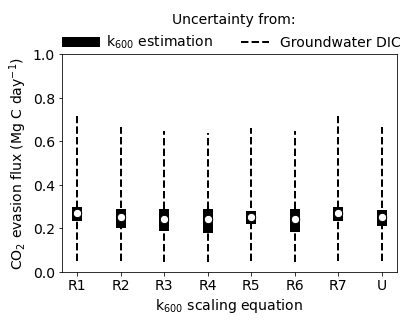

In [13]:
### plot test 1 results 

plt.rcParams.update({'font.size': 14,
                    'lines.markersize':8,
                    'lines.markeredgewidth':1,
                    'lines.linewidth':2})

fig,ax=plt.subplots(1,1)
    
query1 = f'gw_used=="mean"'
testdf1 = results.query(query1)

query2 = f'gw_used=="low"'
testdf2 = results.query(query2)

query3 = f'gw_used=="high"'
testdf3 = results.query(query3)

k600_flux = [] # this appends a list of fluxes with mean gw and with central k600 

klist_plot = ['r1','r2','r3','r4','r5','r6','r7','ulseth']

for i,k in enumerate(klist_plot):
    tempy1 = testdf1.loc[testdf1['k600_used']==k,'fco2']/1e6

    tempy1_low=testdf1.loc[testdf1['k600_used']==k+'_low','fco2']/1e6
    tempy1_high=testdf1.loc[testdf1['k600_used']==k+'_high','fco2']/1e6
    
    tempy2 = testdf2.loc[testdf2['k600_used']==k,'fco2']/1e6
    tempy3 = testdf3.loc[testdf3['k600_used']==k,'fco2']/1e6


    ax.plot([k,k],[tempy1_low,tempy1_high],c='k',lw=10)
    
    ax.plot([k,k],[tempy2,tempy3],ls='--',c='k',lw=2)
    
    ax.scatter(k,tempy1,edgecolor='k',zorder=2,s=70,facecolor='w')
    
    k600_flux.append(tempy1)
 
    
plt.xticks([0,1,2,3,4,5,6,7],['R1','R2','R3','R4','R5','R6','R7','U'])
plt.xlabel('k$_{600}$ scaling equation')
plt.ylabel('CO$_{2}$ evasion flux (Mg C day$^{-1}$)')
plt.legend(['k$_{600}$ estimation','Groundwater DIC'],frameon=False,title='Uncertainty from:',ncol=2,bbox_to_anchor=[1.05,1.25])
plt.ylim([0,1])
    
fig.savefig('plots/Fig4_test1_uncertainty.pdf',bbox_inches='tight')

In [12]:
##### some print statements

query0 = f'gw_used=="mean"'

query1 = f'gw_used=="mean"'
testdf1 = results.query(query1)

query2 = f'gw_used=="low"'
testdf2 = results.query(query2)

query3 = f'gw_used=="high"'
testdf3 = results.query(query3)

print(f'With mean groundwater DIC and central k600, fCO2 ranges {round(np.min(k600_flux),3)}-{round(np.max(k600_flux),3)}')
print(f'With mean groundwater DIC and central k600, fCO2 mean {round(np.mean(k600_flux),3)}')

print(f'With mean groundwater DIC and varying k600 (5-95%), fCO2 ranges {round(np.min(testdf1["fco2"]/1e6),3)}-{round(np.max(testdf1["fco2"]/1e6),3)}')

print(f'Varying groundwater DIC, fCO2 ranges {round(np.min(testdf2["fco2"]/1e6),3)}-{round(np.max(testdf3["fco2"]/1e6),3)}')

With mean groundwater DIC and central k600, fCO2 ranges 0.241-0.271
With mean groundwater DIC and central k600, fCO2 mean 0.253
With mean groundwater DIC and varying k600 (5-95%), fCO2 ranges 0.201-0.277
Varying groundwater DIC, fCO2 ranges 0.038-0.734
